In [1]:
import json
from pathlib import Path
from itertools import islice
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

In [2]:
#Load json.
def load_dataset(path: Path):
    with open(path, 'r') as data_file:
        for line in data_file:
            yield json.loads(line)
        

In [3]:
#Import data
LuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/Luxury_Beauty.json'))
mLuxuryB = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Luxury_Beauty/meta_Luxury_Beauty.json'))
PrimePantry = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Prime_Pantry/Prime_Pantry.json'))
mPrimePantry = load_dataset(
    Path('/Users/linxisarah/Desktop/DV_MidTerm/amazon_data/Prime_Pantry/meta_Prime_Pantry.json'))

In [4]:
#Format Data as DataFrame
LuxuryB = pd.DataFrame(LuxuryB)
mLuxuryB = pd.DataFrame(mLuxuryB)
Prime = pd.DataFrame(PrimePantry)
mPrime = pd.DataFrame(mPrimePantry)

In [5]:
#Tidy the data for Luxury Beauty
LuxuryB = LuxuryB.loc[:, ['asin', 'overall', 'reviewTime','verified']]

#Only select the data where the verified purchase is Ture.
LuxuryBT = LuxuryB[LuxuryB['verified'] == True]
LuxuryBT.drop(['verified'], axis = 1, inplace = True)

mLuxuryB = mLuxuryB.loc[:, ['asin', 'title', 'price', 'brand', 'main_cat']]
DF1 = pd.merge(LuxuryBT, mLuxuryB, how = "inner", on = "asin")
DF1['reviewTime'] = pd.to_datetime(DF1.reviewTime)


/Users/linxisarah/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
# Redefine the brand by using the first name of the title
##Please Note that the brand called 'var' might be the result for the titles which are unable to show the actual names.
##We would still consider it, however it might be the sum for all products which don't have a proper title.
# new data frame with split value columns 
new = DF1["title"].str.split(" ", n = 1, expand = True) 
  
# making separate first name column from new data frame 
DF1["brand"]= new[0] 

In [7]:
#Tidy the data for Prime Pantry
Prime = Prime.loc[:, ['asin', 'overall', 'reviewTime','verified']]
#Only select the data where the verified purchase is Ture.
PrimeT = Prime[Prime['verified'] == True]
PrimeT.drop(['verified'], axis = 1, inplace = True)

mPrime = mPrime.loc[:, ['asin', 'title', 'price', 'brand', 'main_cat']]
DF2 = pd.merge(PrimeT, mPrime, how = "inner", on = "asin")
DF2['reviewTime'] = pd.to_datetime(DF2.reviewTime)
DF2['main_cat'].fillna('Prime Pantry', inplace=True)

/Users/linxisarah/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [8]:
#Just a reminder here
if PrimeT.shape[0] < DF2.shape[0]:
    print("Some reviews are of products are not in the metadata")

Some reviews are of products are not in the metadata


In [9]:
#Set-up the time range
def add_first_review_time(data):
    min_review_time = min(data['reviewTime'])
    max_review_time = max(data['reviewTime'])
    data['firstReviewTime'] = min_review_time
    if ((max_review_time - min_review_time) / np.timedelta64(1, 'M')) >= 6:
        reviewed_by_at_least_six_motnths = True
    else:
        reviewed_by_at_least_six_motnths = False
    data['reviewedByAtLeastSixMotnths'] = reviewed_by_at_least_six_motnths
    return data

In [10]:
DF1 = DF1.groupby('asin').apply(add_first_review_time)
DF2 = DF2.groupby('asin').apply(add_first_review_time)

In [11]:
DF1['numMonthsSinceFirstReview'] = ((DF1['reviewTime'] - DF1['firstReviewTime']) / np.timedelta64(1, 'M')).astype(int)
DF2['numMonthsSinceFirstReview'] = ((DF2['reviewTime'] - DF2['firstReviewTime']) / np.timedelta64(1, 'M')).astype(int)

In [12]:
#Select the products which have been reviewed more than 6 month and only take the data for the first 6 month.
DF1x = DF1[(DF1['reviewedByAtLeastSixMotnths'] == True) & (DF1['numMonthsSinceFirstReview'] < 6)]
DF2x = DF2[(DF2['reviewedByAtLeastSixMotnths'] == True) & (DF2['numMonthsSinceFirstReview'] < 6)]

In [13]:
#Count the frequency of reviews in each month for each product
DF2_Count = DF2x.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF1_Count = DF1x.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")

In [14]:
#Calculate the mean value of review of each month
DF1_Count.loc[:, 'MonthSum'] = DF1_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.sum)
DF1_Count.loc[:, 'Mean'] = DF1_Count['MonthSum']/len(DF1_Count.brand.unique())
DF1_Count['Mean'] = round(DF1_Count['Mean'], 1)


DF2_Count.loc[:, 'MonthSum'] = DF2_Count.groupby(['numMonthsSinceFirstReview'])['Count'].transform(np.sum)
DF2_Count.loc[:, 'Mean'] = DF2_Count['MonthSum']/len(DF2_Count.brand.unique())
DF2_Count['Mean'] = round(DF2_Count['Mean'], 1)

In [15]:
DF1_Count['Cat'] = 'Luxury Beauty'
DF2_Count['Cat'] = 'Prime Pantry'

P1_D = pd.concat([DF1_Count,DF2_Count])
P1_D = P1_D[['numMonthsSinceFirstReview','Mean', 'Cat']]
P1_D = P1_D.drop_duplicates(['numMonthsSinceFirstReview','Mean', 'Cat'])
P1_D.sort_values('numMonthsSinceFirstReview', inplace=True)
P1_D.reset_index(inplace=True)
P1_D.drop("index", axis=1, inplace=True)
P1_D = P1_D.pivot(index='numMonthsSinceFirstReview', columns='Cat', values='Mean')
P1_D.reset_index(inplace=True)
P1_D

Cat,numMonthsSinceFirstReview,Luxury Beauty,Prime Pantry
0,0,19.0,8.9
1,1,5.8,4.4
2,2,6.1,5.2
3,3,5.9,5.3
4,4,6.6,5.8
5,5,6.7,5.8


In [16]:
from matplotlib.lines import Line2D

In [17]:
#Dataset for Price
DF1_Price = DF1x.groupby(["asin", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
Price1 = DF1x[['asin','price']]
Price1 = Price1.drop_duplicates(['asin','price'])
DF1_Price = pd.merge(Price1, DF1_Price, how = "inner", on = "asin")
DF1_Price['Cat'] = 'Luxury Beauty'


DF2_Price = DF2x.groupby(["asin", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
Price2 = DF2x[['asin','price']]
Price2 = Price2.drop_duplicates(['asin','price'])
DF2_Price = pd.merge(Price2, DF2_Price, how = "inner", on = "asin")
DF2_Price['Cat'] = 'Prime Pantry'

DF_Price = pd.concat([DF1_Price, DF2_Price])
DF_Price.reset_index(inplace = True)
DF_Price.drop('index', axis=1, inplace = True)

In [18]:
DF_Price

,asin,price,numMonthsSinceFirstReview,Count,Cat
0,B00004U9V2,$30.00,0,2,Luxury Beauty
1,B00004U9V2,$30.00,5,2,Luxury Beauty
2,B00005A77F,$15.99,0,2,Luxury Beauty
3,B00005A77F,$15.99,5,2,Luxury Beauty
4,B00005NDTD,$18.00,0,2,Luxury Beauty
...,...,...,...,...,...
49724,B01HI76EWA,$7.96,4,1,Prime Pantry
49725,B01HI76EWA,$7.96,5,1,Prime Pantry
49726,B01HI8JVI8,$6.82,0,1,Prime Pantry
49727,B01HI8JVI8,$6.82,1,1,Prime Pantry


In [19]:
DF_Price.dropna(inplace = True) 
# new data frame with split value columns 
new = DF_Price["price"].str.split("$", n = 1, expand = True) 
  
# making separate first name column from new data frame 
DF_Price["price"]= new[1] 

#Change price from string format to numerical format
DF_Price['price'] = pd.to_numeric(DF_Price['price'], errors='coerce')

DF_Price.loc[:, 'Price_Range'] = DF_Price.groupby(['Cat'])['price'].transform(lambda x: np.where(x > np.quantile(x, 0.75), 'High', 
         (np.where(x < np.quantile(x, 0.25), 'Low', 'Medium'))))

DF_Price

,asin,price,numMonthsSinceFirstReview,Count,Cat,Price_Range
0,B00004U9V2,30.00,0,2,Luxury Beauty,Medium
1,B00004U9V2,30.00,5,2,Luxury Beauty,Medium
2,B00005A77F,15.99,0,2,Luxury Beauty,Low
3,B00005A77F,15.99,5,2,Luxury Beauty,Low
4,B00005NDTD,18.00,0,2,Luxury Beauty,Low
...,...,...,...,...,...,...
49724,B01HI76EWA,7.96,4,1,Prime Pantry,Medium
49725,B01HI76EWA,7.96,5,1,Prime Pantry,Medium
49726,B01HI8JVI8,6.82,0,1,Prime Pantry,Medium
49727,B01HI8JVI8,6.82,1,1,Prime Pantry,Medium


In [20]:
#len(DF_Price.asin.unique())
Products = DF_Price.groupby(['Cat',"Price_Range"])['asin'].transform(lambda x: len(x.unique()))
Products = pd.DataFrame(Products)
Products = Products.drop_duplicates(['asin'])

#Match Data
Products = pd.merge(Products, DF_Price, left_index = True, right_index = True)
Products.rename({'asin_x': 'Sum_of_asin'}, axis=1, inplace=True)
Products = Products[['Cat','Price_Range','Sum_of_asin']]

Products

,Cat,Price_Range,Sum_of_asin
0,Luxury Beauty,Medium,3051
2,Luxury Beauty,Low,1383
9,Luxury Beauty,High,1449
20184,Prime Pantry,Low,1319
20228,Prime Pantry,Medium,3143
20234,Prime Pantry,High,1675


In [21]:
DF_PriceRange = DF_Price.groupby(["Price_Range", "numMonthsSinceFirstReview", 'Cat']).size().reset_index(name="Count")
DF_PriceRange = pd.merge(DF_PriceRange, Products, on=['Cat', 'Price_Range'])

DF_PriceRange['Mean'] = DF_PriceRange['Count']/DF_PriceRange['Sum_of_asin']
DF_PriceRange

,Price_Range,numMonthsSinceFirstReview,Cat,Count,Sum_of_asin,Mean
0,High,0,Luxury Beauty,1449,1449,1.000000
1,High,1,Luxury Beauty,297,1449,0.204969
2,High,2,Luxury Beauty,324,1449,0.223602
3,High,3,Luxury Beauty,353,1449,0.243616
4,High,4,Luxury Beauty,369,1449,0.254658
5,High,5,Luxury Beauty,363,1449,0.250518
6,High,0,Prime Pantry,1675,1675,1.000000
7,High,1,Prime Pantry,698,1675,0.416716
8,High,2,Prime Pantry,771,1675,0.460299
9,High,3,Prime Pantry,771,1675,0.460299


In [22]:
P2_D = DF_PriceRange.groupby('Cat').apply(lambda x: x.pivot(index ='numMonthsSinceFirstReview', 
                                                columns= 'Price_Range', values='Mean'))

P2_D.reset_index(inplace = True)
P2_D

Price_Range,Cat,numMonthsSinceFirstReview,High,Low,Medium
0,Luxury Beauty,0,1.000000,1.000000,1.000000
1,Luxury Beauty,1,0.204969,0.227766,0.233038
2,Luxury Beauty,2,0.223602,0.258858,0.228122
3,Luxury Beauty,3,0.243616,0.235719,0.235333
4,Luxury Beauty,4,0.254658,0.266811,0.236644
5,Luxury Beauty,5,0.250518,0.265365,0.251065
6,Prime Pantry,0,1.000000,1.000000,1.000000
7,Prime Pantry,1,0.416716,0.549659,0.506522
8,Prime Pantry,2,0.460299,0.595148,0.527521
9,Prime Pantry,3,0.460299,0.601213,0.531976


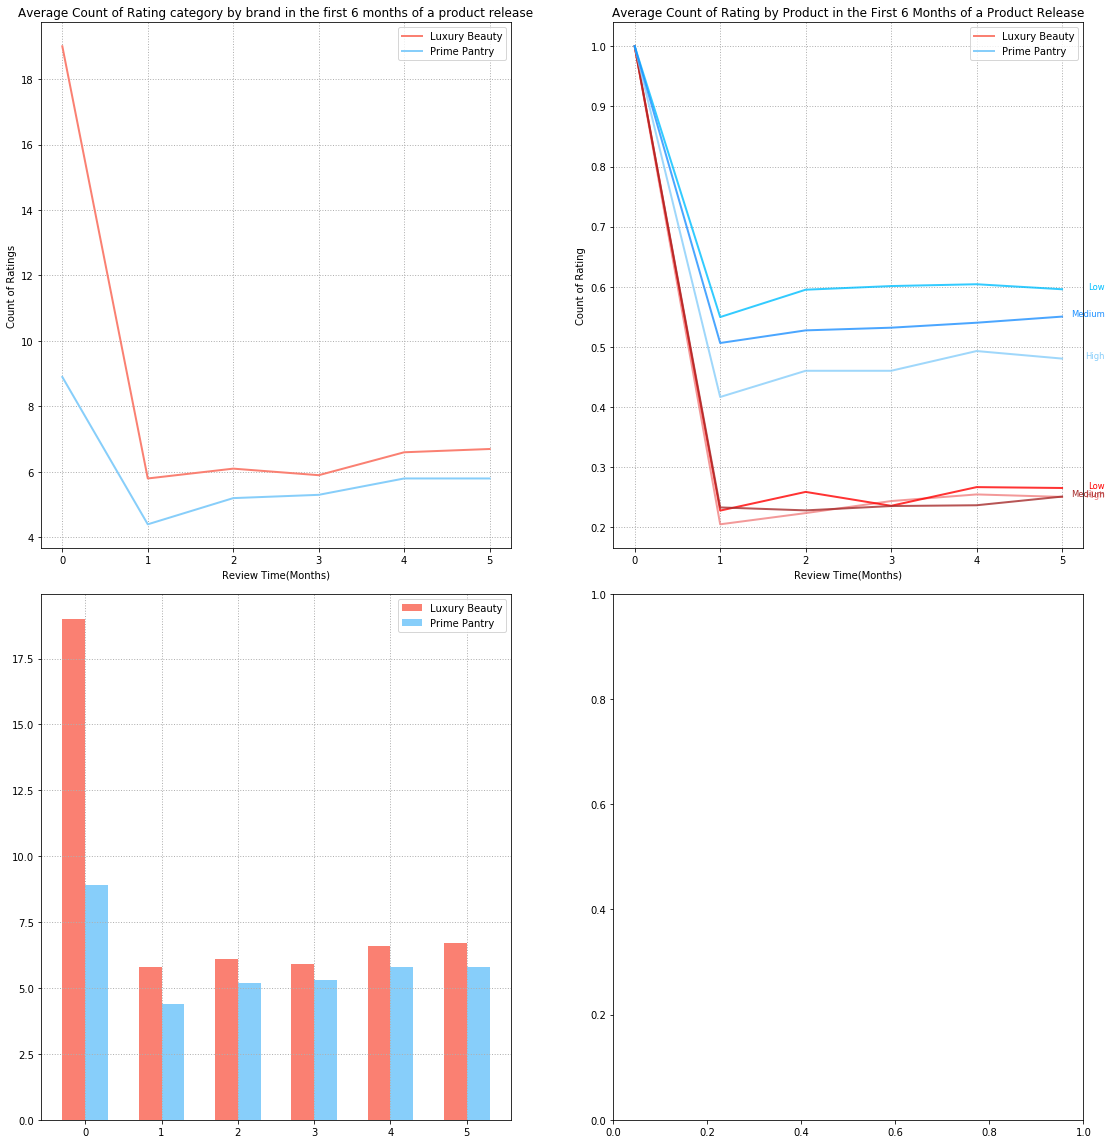

In [57]:
fig = plt.figure(figsize=(16, 16))

# add chart
AX0 = fig.add_subplot(2, 2, 1)
AX1 = fig.add_subplot(2, 2, 2)
AX2 = fig.add_subplot(2, 2, 3)
AX3 = fig.add_subplot(2, 2, 4)


AX0.grid(linestyle=":", linewidth=1)

AX0.plot(P1_D['numMonthsSinceFirstReview'], P1_D['Luxury Beauty'], marker='', 
         color='salmon', linewidth=2, alpha = 1, label='Luxury Beauty')

AX0.plot(P1_D['numMonthsSinceFirstReview'], P1_D['Prime Pantry'], marker='', 
         color='lightskyblue', linewidth=2, alpha = 1, label = 'Prime Pantry')

AX0.legend(loc='best')

## Add titles
AX0.set_title("Average Count of Rating category by brand in the first 6 months of a product release", 
              fontsize=12, fontweight=0)
AX0.set_xlabel('Review Time(Months)')
AX0.set_ylabel('Count of Ratings')


#AX1
AX1.grid(linestyle=":", linewidth=1)
P2_D1 = P2_D[P2_D['Cat'] == 'Luxury Beauty']
P2_D2 = P2_D[P2_D['Cat'] == 'Prime Pantry']

palette1 = ['lightcoral', 'red','brown']
palette2 = ['lightskyblue','deepskyblue','dodgerblue']

# multiple line plot
num=0
for column in P2_D1.drop(['Cat','numMonthsSinceFirstReview'], axis=1):
   num+=1
   AX1.plot(P2_D1['numMonthsSinceFirstReview'], P2_D1[column], marker='', 
             color = palette1[num-1], linewidth=2, alpha=0.8)

num=0
for column in P2_D2.drop(['Cat','numMonthsSinceFirstReview'], axis=1):
   num+=1
   AX1.plot(P2_D2['numMonthsSinceFirstReview'], P2_D2[column], marker='', color = palette2[num-1], linewidth=2, alpha=0.8)

num=0
for i in P2_D1.values[5][1:]:
   num+=1
   name=list(P2_D1)[num]
   if name != 'numMonthsSinceFirstReview':
      AX1.text(5.5, i, name, size='small', horizontalalignment='right', color = palette1[num-2])

num=0
for i in P2_D2.values[5][1:]:
   num+=1
   name=list(P2_D2)[num]
   if name != 'numMonthsSinceFirstReview':
      AX1.text(5.5, i, name, size='small', horizontalalignment='right', color = palette2[num-2])

legend_elements = [Line2D([0], [0], color='salmon', lw=2, label='Luxury Beauty'),
                   Line2D([0], [0], color='lightskyblue', lw=2, label='Prime Pantry')]

AX1.legend(handles=legend_elements, loc='best')

## Add titles
AX1.set_title("Average Count of Rating by Product in the First 6 Months of a Product Release", 
              fontsize=12, fontweight=0)
AX1.set_xlabel('Review Time(Months)')
AX1.set_ylabel('Count of Rating')


#Alternative for AX0
AX2.grid(linestyle=":", linewidth=1)

AX2.bar(P1_D['numMonthsSinceFirstReview']-0.15, P1_D['Luxury Beauty'],
         color='salmon', linewidth=2, alpha = 1, label='Luxury Beauty', width = 0.3)

AX2.bar(P1_D['numMonthsSinceFirstReview']+0.15, P1_D['Prime Pantry'],
         color='lightskyblue', linewidth=2, alpha = 1, label = 'Prime Pantry', width = 0.3)

AX2.legend()

fig.tight_layout()

plt.show()
fig.savefig("Plot(XI LIN).pdf")

In [52]:
palettex = ['lightcoral', 'indianred','brown']
palettex[2-1]

'indianred'

(0, 10)

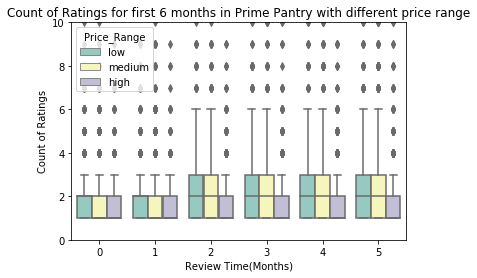

In [197]:
sns.boxplot(x="numMonthsSinceFirstReview", y="Count", hue="Price_Range", data=DF_Price, palette="Set3", linewidth=1.5).set(
xlabel='Review Time(Months)', ylabel='Count of Ratings', 
    title = "Count of Ratings for first 6 months in Prime Pantry with different price range")

plt.ylim(0,10)

,Price_Range,numMonthsSinceFirstReview,Count
0,high,0,1675
1,high,1,698
2,high,2,771
3,high,3,771
4,high,4,826
5,high,5,805
6,low,0,1319
7,low,1,725
8,low,2,785
9,low,3,793


In [199]:
P2_D1 = DF_PriceRange.pivot(index='numMonthsSinceFirstReview', columns='Price_Range', values='Count')
P2_D1.reset_index(inplace=True)


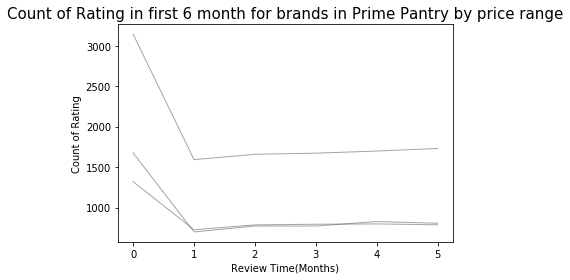

In [202]:
for column in P2_D1.drop('numMonthsSinceFirstReview', axis=1):
    plt.plot(P2_D1['numMonthsSinceFirstReview'], P2_D1[column], 
             color='dimgrey', linewidth = 1, alpha = 0.6)

plt.title("Count of Rating in first 6 month for brands in Prime Pantry by price range", 
              fontsize=15, fontweight=0)
plt.xlabel('Review Time(Months)')
plt.ylabel('Count of Rating')

plt.show()


(array([   0.,    0.,   10.,   36.,  246.,  141.,  295.,  350.,  358.,
         523.,  376.,  472.,  868.,  718., 1253.,  531.,  626.,  651.,
         668., 1137.,  319.,  408.,  495.,  381., 1076.,  258.,  357.,
         406.,  305.,  664.,  164.,  354.,  349.,  182.,  538.,   96.,
         206.,  248.,  206.,  427.,  122.,  126.,  169.,  114.,  311.,
          84.,  138.,  101.,   88.,  384.,   89.,   79.,   92.,  109.,
         188.,   29.,   48.,  127.,   48.,  202.,   41.,   82.,   79.,
          44.,  129.,   38.,   41.,   75.,   46.,  105.,   37.,   84.,
          53.,   51.,  117.,   40.,   31.,   32.,   22.,  140.,   31.,
          14.,   37.,   39.,  106.,   18.,   40.,   17.,   28.,   79.,
          20.,   19.,   22.,   26.,   54.,   14.,   12.,   12.,   10.,
          54.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8

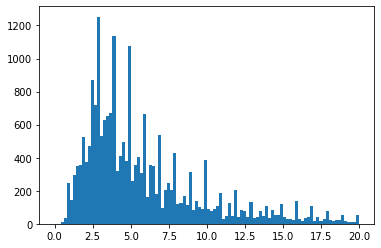

In [191]:
plt.hist(DF_Price['price'], bins=100, range=(0,20))

In [189]:
DF_Price.price.mode()

0    2.99
dtype: float64

(0, 5)

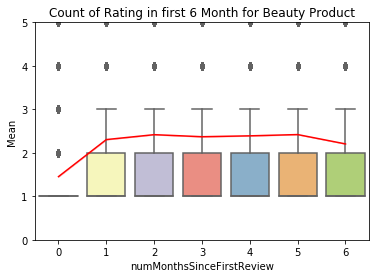

In [127]:
#Just some plots attempts...
##Boxplot
sns.boxplot(x="numMonthsSinceFirstReview", y="Count", data = DF_Count, palette="Set3", linewidth=1.5).set(
xlabel='Review Month', ylabel='Count of Rating', 
    title = "Count of Rating in first 6 Month for Beauty Product")

sns.lineplot(y= DF_Count.Mean,x = DF_Count.numMonthsSinceFirstReview, color = "red")


plt.ylim(0,5)


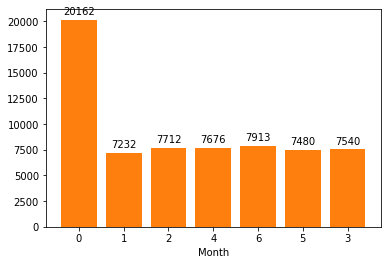

In [159]:
##Barchart

x = np.arange(7)
y = list(DF_Count.MonthSum.unique())

fig, ax = plt.subplots()

plt.bar(x, y)
plt.xlabel('Month')
plt.xticks(x, DF_Count.numMonthsSinceFirstReview.unique())



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(plt.bar(x, y))

plt.show()

In [154]:
A = pd.DataFrame(data = (DF_Count.MonthSum.unique(), DF_Count.numMonthsSinceFirstReview.unique())).T
A.sort_values(by = [1])

,0,1
0,20162,0
1,7232,1
2,7712,2
6,7540,3
3,7676,4
5,7480,5
4,7913,6


In [148]:
A = list(DF_Count.MonthSum.unique())
A.sort()
A

[7232, 7480, 7540, 7676, 7712, 7913, 20162]

In [92]:
df.groupby(["p", "q"]).size()

p  q
a  1    2
   2    1
b  1    1
s  3    2
dtype: int64

In [106]:
df = pd.DataFrame({'p':('a','a','a','b','a','s','s'), 'q':(1,2,3,1,1,3,4)})
df

,p,q
0,a,1
1,a,2
2,a,3
3,b,1
4,a,1
5,s,3
6,s,4


In [109]:
df.loc[:, 'PriceRange'] = df.groupby(['p'])['q'].transform(lambda x: np.where(x > np.quantile(x, 0.75), 'high', 
         (np.where(x < np.quantile(x, 0.40), 'low', 'medium'))))
df

,p,q,PriceRange
0,a,1,low
1,a,2,medium
2,a,3,high
3,b,1,medium
4,a,1,low
5,s,3,low
6,s,4,high


In [146]:
x = pd.DataFrame({'x':('5','4','3','5','7')})
df = pd.concat([df, x], axis=1, sort=False)

df = pd.DataFrame(df)

#df.brand.unique()

In [105]:
df

,p,q,PriceRange
0,a,1,medium
1,a,2,high
2,b,1,medium
3,a,1,medium
4,s,3,low
5,s,4,high


In [147]:
df

,p,q,x
0,a,1,5
1,a,2,4
2,b,1,3
3,a,1,5
4,s,3,7
5,s,3,NaN


In [100]:
DF_Count = DFx.groupby(["brand", "numMonthsSinceFirstReview"]).size().reset_index(name="Count")
DF_Count

array(['w', 'e', 'r', nan], dtype=object)

In [101]:
df_C = df.groupby(["x", "q",'']).size().reset_index(name="Count")
df_C

,x,q,Count
0,e,1,1
1,r,1,1
2,r,3,1
3,w,1,1
4,w,2,1


In [76]:
df = df.groupby(["p", "q"]).size().reset_index(name="F")
df

,p,q,F
0,a,1,2
1,a,2,1
2,b,1,1
3,s,3,2


In [77]:
df['mean'] = df.groupby(['q'])['F'].transform(np.mean)
df

,p,q,F,mean
0,a,1,2,1.5
1,a,2,1,1.0
2,b,1,1,1.5
3,s,3,2,2.0


In [78]:
df['sum'] = df.groupby(['q'])['F'].transform(np.sum)
df

,p,q,F,mean,sum
0,a,1,2,1.5,3
1,a,2,1,1.0,1
2,b,1,1,1.5,3
3,s,3,2,2.0,2


In [79]:
df['Amean'] = df['sum']/len(df.p.unique())
df
#len(df.p.unique())

,p,q,F,mean,sum,Amean
0,a,1,2,1.5,3,1.000000
1,a,2,1,1.0,1,0.333333
2,b,1,1,1.5,3,1.000000
3,s,3,2,2.0,2,0.666667


In [60]:
df['freq'] = df.groupby('p')['q'].transform(np.sum)
df

,p,q,freq
0,a,1,11
1,b,2,223
2,s,1,11
3,s,1,11
4,b,2,223
5,a,1,11
6,b,3,223
